# Time Series Conv1D Algorithm
### 1D convolution layer (temporal convolution)

This algorithm is used to forecast FOREX prices for the EURJPY pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position -1** if the prediction indicates that the price will go down in the next hour

In [37]:
import pandas as pd
import numpy as np
import MetaTrader5 as mt5
import ta
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from UsefulFunctions import data, backtest, display, ai

**Initiating bound between MetaTrader5 and Python**

In [4]:
# To be able to connect to MetaTrader5 you need to be already logged in with your trading account
mt5.initialize()

True

In [5]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("EURJPY", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,145.11,145.17,145.05,145.13,471,40,0
2015-01-02 09:00:00,145.12,145.22,144.95,145.18,953,40,0
2015-01-02 10:00:00,145.19,145.31,144.98,144.98,1448,40,0
2015-01-02 11:00:00,144.97,145.18,144.88,145.18,1298,40,0
2015-01-02 12:00:00,145.17,145.18,145.00,145.12,826,40,0


In [6]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,145.11,145.17,145.05,145.13,471
2015-01-02 09:00:00,145.12,145.22,144.95,145.18,953
2015-01-02 10:00:00,145.19,145.31,144.98,144.98,1448
2015-01-02 11:00:00,144.97,145.18,144.88,145.18,1298
2015-01-02 12:00:00,145.17,145.18,145.00,145.12,826


## Feature engineering 
**Creating new input variables from raw data**

In [8]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,145.13,NaN
2015-01-02 09:00:00,145.18,0.000345
2015-01-02 10:00:00,144.98,-0.001378
2015-01-02 11:00:00,145.18,0.001380
2015-01-02 12:00:00,145.12,-0.000413


In [9]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)

WR = ta.momentum.WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=21, fillna=False)
df_copy2["WR 21"] = WR.williams_r().shift(1)

df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21
time,,,,,,,,
2015-01-06 20:00:00,141.24,0.000000,141.808667,143.288500,0.270861,0.533607,30.505035,-89.325843
2015-01-06 21:00:00,141.30,0.000425,141.726667,143.223667,0.241072,0.543703,30.505035,-81.052632
2015-01-06 22:00:00,140.99,-0.002194,141.649333,143.159000,0.248106,0.555235,31.465593,-76.404494
2015-01-06 23:00:00,140.74,-0.001773,141.566667,143.092500,0.287897,0.584874,29.300953,-93.820225
2015-01-07 00:00:00,140.79,0.000355,141.478667,143.018500,0.311163,0.618906,27.710587,-99.473684


In [10]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Refer to the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,WR 21,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-07 01:00:00,140.86,0.000497,141.378000,142.946333,0.306893,0.646753,28.513361,-87.922705,140.79,140.74,140.99,141.30,141.24
2015-01-07 02:00:00,140.94,0.000568,141.302667,142.873667,0.273620,0.663392,29.644890,-84.158416,140.86,140.79,140.74,140.99,141.30
2015-01-07 03:00:00,141.32,0.002696,141.266000,142.802667,0.243541,0.660060,30.937298,-79.274611,140.94,140.86,140.79,140.74,140.99
2015-01-07 04:00:00,141.32,0.000000,141.251333,142.740000,0.217227,0.644497,36.655141,-59.585492,141.32,140.94,140.86,140.79,140.74
2015-01-07 05:00:00,141.33,0.000071,141.215333,142.678667,0.233390,0.618170,36.655141,-58.064516,141.32,141.32,140.94,140.86,140.79


## Implementing Machine Learning

In [12]:
# Splitting the data into features and labels for the ML model 
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

# Data si splitted in training, validation and test datasets
# Refer to the docstring of the "split_data" function from the data.py file
X_train, y_train, X_temp, y_temp = data.split_data(X, y, 70)
X_val, y_val, X_test, y_test = data.split_data(X_temp, y_temp, 50)

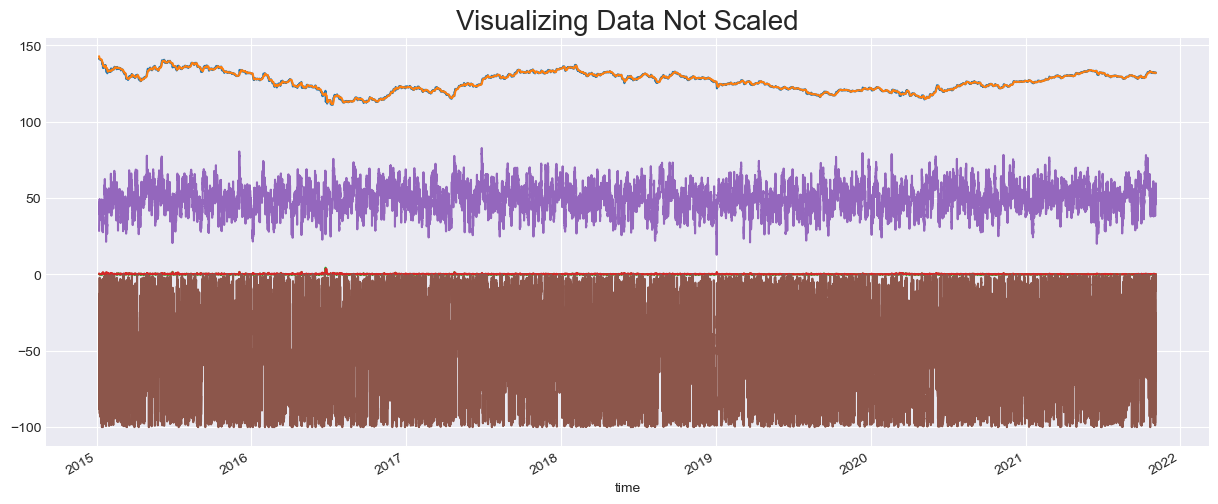

In [13]:
# Plotting features before standardization to visualize their unequal scales
X_train.iloc[:,:6].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Data Not Scaled", fontsize=20)
plt.show()

## Plotting the feature data to assess its distribution and determine if it follows a normal distribution

In [15]:
import seaborn as sns

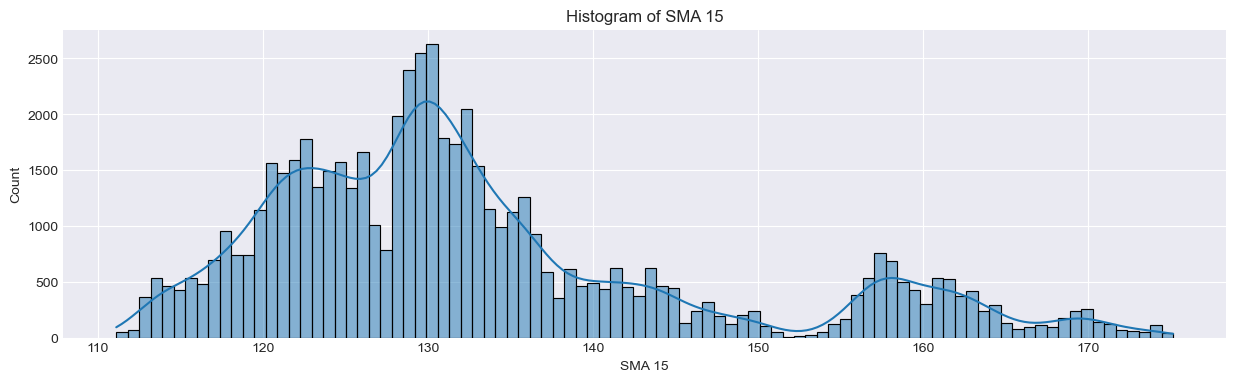

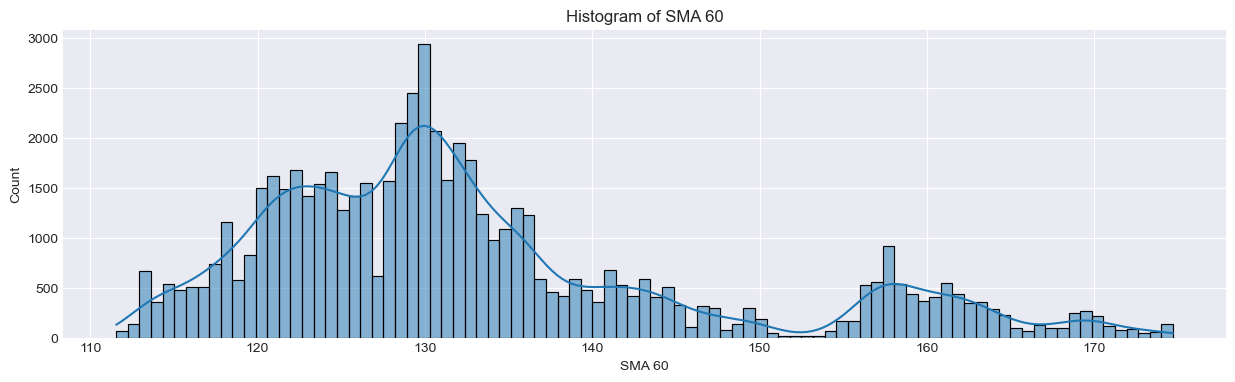

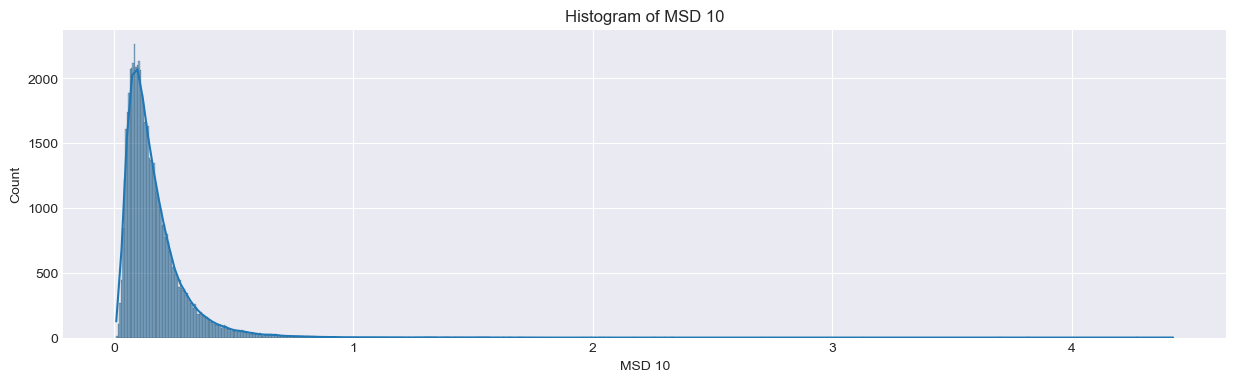

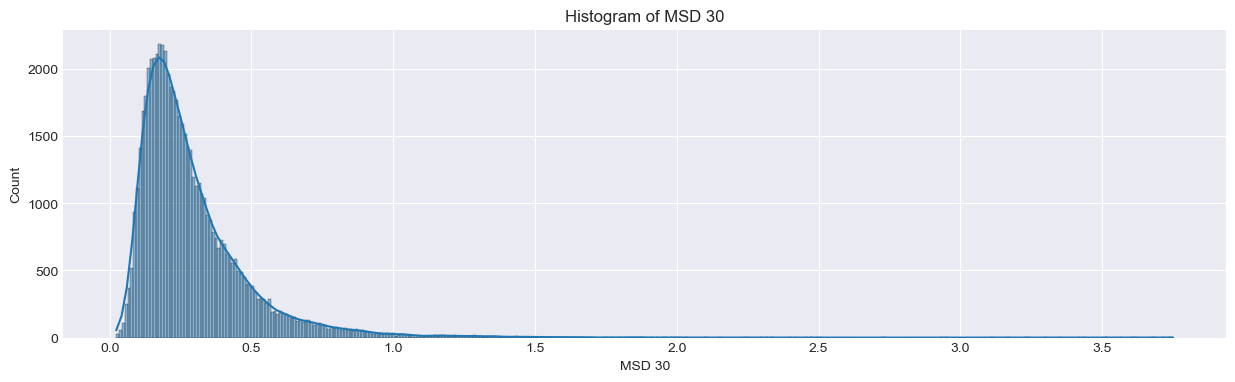

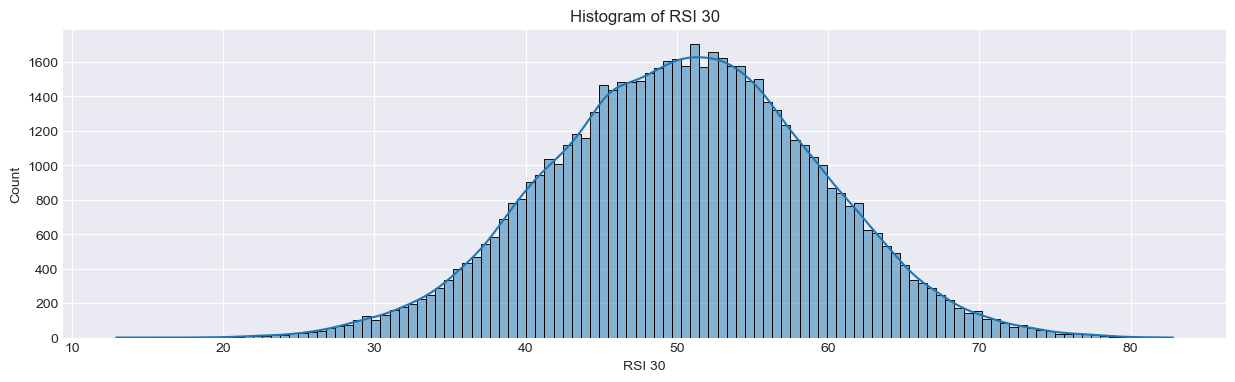

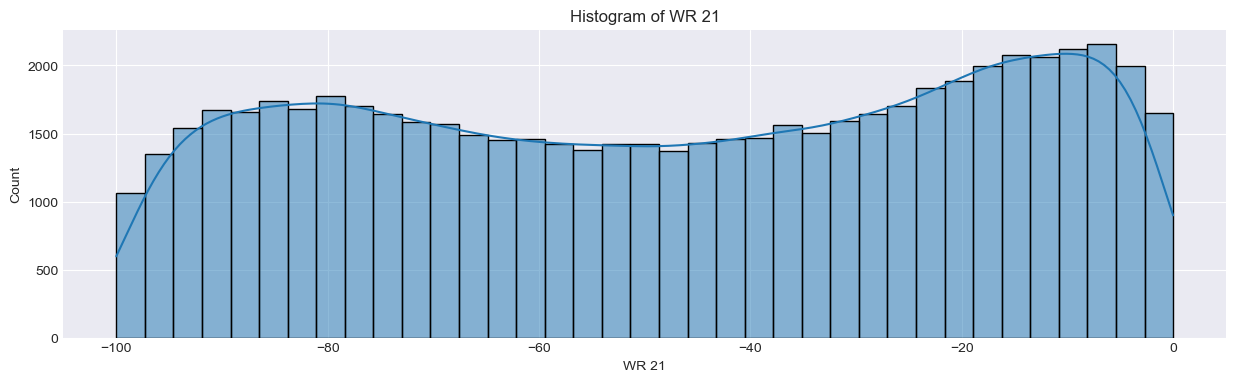

In [16]:
# Plotting a histogram for all features excluding previous bar prices
for col in X_train.iloc[:,:6].columns:
    plt.figure(figsize=(15, 4))
    sns.histplot(df_copy2[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

### Conclusion:
**Most features are not normally distributed, so the appropriate scaler to apply will be MinMaxScaler**

### Applying MinMaxScaler Scaler

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

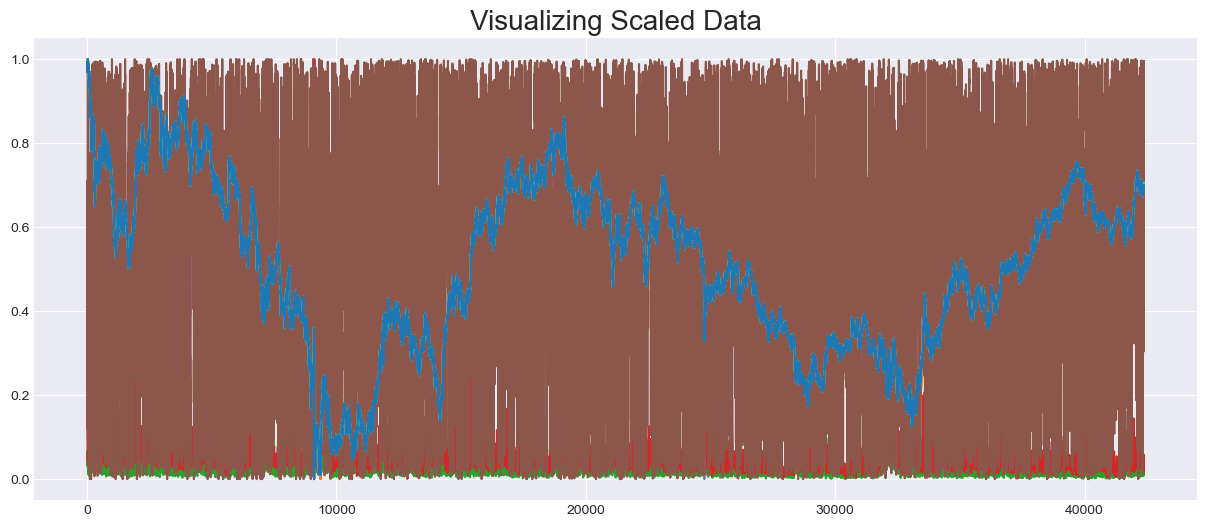

In [21]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Scaled Data", fontsize=20)
plt.show()

**Transforming 2D data into 3D datasets**

This is the proper data shape received by the Conv1D Layer|

In [23]:
# Refer to the docstring of the "create_3d_data" function from the data.py file
X_train_3d, y_train_3d = data.create_3d_data(X_train_scaled, np.sign(y_train), 5)
X_val_3d, y_val_3d = data.create_3d_data(X_val_scaled, np.sign(y_val), 5)
X_test_3d, y_test_3d = data.create_3d_data(X_test_scaled, np.sign(y_test), 5)

### Note:

**This model is not focused on classification, but I’ve observed that it performs more accurately when the labels represent the direction of price movements (using values of 1, 0, or -1). In capital markets, these directional signals are crucial for trading, as they reflect the most important aspect—whether the price is moving up, down, or staying flat**

In [25]:
# Showing the new shape of the X_train dataset
print(f"Old shape of X_train dataset    {X_train_scaled.shape}")
print(f"New shape of X_train dataset    {X_train_3d.shape}")

Old shape of X_train dataset    (42378, 11)
New shape of X_train dataset    (42373, 5, 11)


**Showing the first 3D row of the new X 3D dataset**

In [27]:
pd.DataFrame(X_train_3d[0])

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,1.000000,0.067353,0.167317,0.223074,0.120773,0.971042,0.969434,0.977477,0.987452,0.985521
1,0.997511,0.997685,0.059816,0.171782,0.239263,0.158416,0.973295,0.971042,0.969434,0.977477,0.987452
2,0.996299,0.995423,0.053003,0.170888,0.257755,0.207254,0.975869,0.973295,0.971042,0.969434,0.977477
3,0.995815,0.993426,0.047042,0.166712,0.339566,0.404145,0.988095,0.975869,0.973295,0.971042,0.969434
4,0.994625,0.991472,0.050703,0.159649,0.339566,0.419355,0.988095,0.988095,0.975869,0.973295,0.971042


In [28]:
# These are the new labels represented as price directions-
pd.DataFrame(y_test_3d).tail()

,0
9071,1.0
9072,-1.0
9073,1.0
9074,-1.0
9075,0.0


In [29]:
# Showing original label values
pd.DataFrame(y_test).tail()

,pct_change
time,
2024-10-03 23:00:00,0.000704
2024-10-04 00:00:00,-0.000654
2024-10-04 01:00:00,0.000537
2024-10-04 02:00:00,-0.000043
2024-10-04 03:00:00,0.000000


**Importing TensorFlow and Required Libraries to Build Conv1D Model**

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv1D, Dropout
from tensorflow.keras.optimizers import Adam
import os

**Prefetching data to make the model run faster**

In [33]:
# Convert both X and y datasets into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_3d, y_train_3d))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_3d, y_val_3d))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_3d, y_test_3d))

# Batch and prefetch
batch_size = 128  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Building the First Conv1D Model

In [240]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu"))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Output Layer
    
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=1,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [242]:
history_model_1 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_1",
                             p_filters=32,
                             p_kernel_size=2,
                             p_strides=1,
                             hidden_layers=2,
                             lr=0.001,
                             early_stopping_ptn=11,
                             reduce_plateau_ptn=5)

Epoch 1/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9768 - mae: 0.9768 - val_loss: 0.9803 - val_mae: 0.9803 - learning_rate: 0.0010
Epoch 2/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9793 - mae: 0.9793 - val_loss: 0.9829 - val_mae: 0.9829 - learning_rate: 0.0010
Epoch 3/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9778 - mae: 0.9778 - val_loss: 0.9846 - val_mae: 0.9846 - learning_rate: 0.0010
Epoch 4/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9773 - mae: 0.9773 - val_loss: 0.9849 - val_mae: 0.9849 - learning_rate: 0.0010
Epoch 5/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9768 - mae: 0.9768 - val_loss: 0.9854 - val_mae: 0.9854 - learning_rate: 0.0010
Epoch 6/25
317/332 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9763 - mae: 0.9763
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9766 - mae: 0.9766 - val_loss: 0.9852 - val_mae: 0.9852 - learning_rate: 0.0010
Ep

**Loading the Model and Showing its Architecture**

In [244]:
from tensorflow.keras.models import load_model

In [245]:
model_1 = load_model("model_experiments/model_1.keras")
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 5, 32)          │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 4, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Conv1D)          │ (None, 3, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer1 (Dropout)        │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3, 1)           │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,965 (27.21 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,644 (18.14 KB)

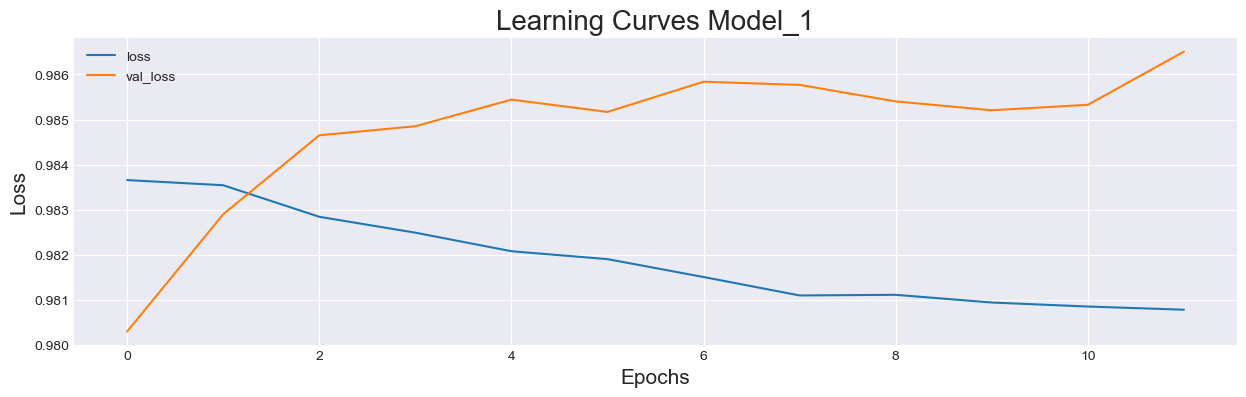

In [246]:
pd.DataFrame(history_model_1.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_1", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [251]:
# Evaluating the model
model_1.evaluate(test_dataset)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9794 - mae: 0.9794 


[0.9789841175079346, 0.9789841175079346]

**Making Predictions**

In [254]:
model_1_preds = model_1.predict(X_test_3d)

284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [255]:
# Showing the shape of the predictions outcome
model_1_preds.shape

(9076, 3, 1)

In [258]:
np.squeeze(model_1_preds).shape

(9076, 3)

In [260]:
# Showing the first predictions from the model
pd.DataFrame(np.squeeze(model_1_preds))

,0,1,2
0,0.594659,0.521122,0.512371
1,0.572724,0.512371,0.499375
2,0.568483,0.499375,0.461781
3,0.555899,0.461781,0.457998
4,0.520887,0.457998,0.476133
...,...,...,...
9071,0.427705,0.362589,0.377296
9072,0.448013,0.377296,0.396449
9073,0.468174,0.396449,0.422312
9074,0.485031,0.422312,0.441306


In [262]:
# Actual shape of the labels
y_test_3d.shape

(9076,)

**This is Not the desired shape for the predictions outcome**

**Key Insights:** 

- The input data (X_test_3d) has 5 time steps ((9076, 5, 11)), but the label data (y_test_3d) has a shape of (9076, 1).
- However, since Conv1D processes over a time dimension, the model is assuming I am predicting a sequence of outputs (one per time step). The current configuration of the input might be resulting in the model predicting for multiple time steps.
- I am expecting a single output for each input sequence.

**After some research**

I found **GlobalAveragePooling1D** is a layer in TensorFlow that performs global average pooling over the temporal dimensions and is often used after convolutional layers in 1D data to reduce the dimensionality of the data by averaging each feature map across the time dimension.   This reduces the output of the convolutional layers down to a fixed-size vector

### Appying GlobalAveragePooling1D Layer

In [268]:
from tensorflow.keras.layers import GlobalAveragePooling1D

In [270]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu"))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Applying GlobalAveragePooling1D Layer
    model.add(GlobalAveragePooling1D())
        
    # Output Layer
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=1,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [272]:
history_model_2 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_2",
                             p_filters=32,
                             p_kernel_size=2,
                             p_strides=1,
                             hidden_layers=2,
                             lr=0.001,
                             early_stopping_ptn=11,
                             reduce_plateau_ptn=5)

Epoch 1/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9789 - mae: 0.9789 - val_loss: 0.9799 - val_mae: 0.9799 - learning_rate: 0.0010
Epoch 2/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9817 - mae: 0.9817 - val_loss: 0.9805 - val_mae: 0.9805 - learning_rate: 0.0010
Epoch 3/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9820 - mae: 0.9820 - val_loss: 0.9757 - val_mae: 0.9757 - learning_rate: 0.0010
Epoch 4/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9816 - mae: 0.9816 - val_loss: 0.9847 - val_mae: 0.9847 - learning_rate: 0.0010
Epoch 5/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9826 - mae: 0.9826 - val_loss: 0.9886 - val_mae: 0.9886 - learning_rate: 0.0010
Epoch 6/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9803 - mae: 0.9803 - val_loss: 0.9825 - val_mae: 0.9825 - learning_rate: 0.0010
Epoch 7/25
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9851 - mae: 0.9851 - val_loss: 0.9877 - val_mae: 0.9877 - learning_rate: 0.0010
Epoch 

**Loading the Model_2 and Showing its Architecture**

In [2106]:
model_2 = load_model("model_experiments/model_2.keras")
model_2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 5, 32)          │           736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 4, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer1 (Conv1D)          │ (None, 3, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer1 (Dropout)        │ (None, 3, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,965 (27.21 KB)

 Trainable params: 2,321 (9.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,644 (18.14 KB)

**Note**

As we can see, the output_layer now has a single value, which is achieved by using the GlobalAveragePooling1D layer

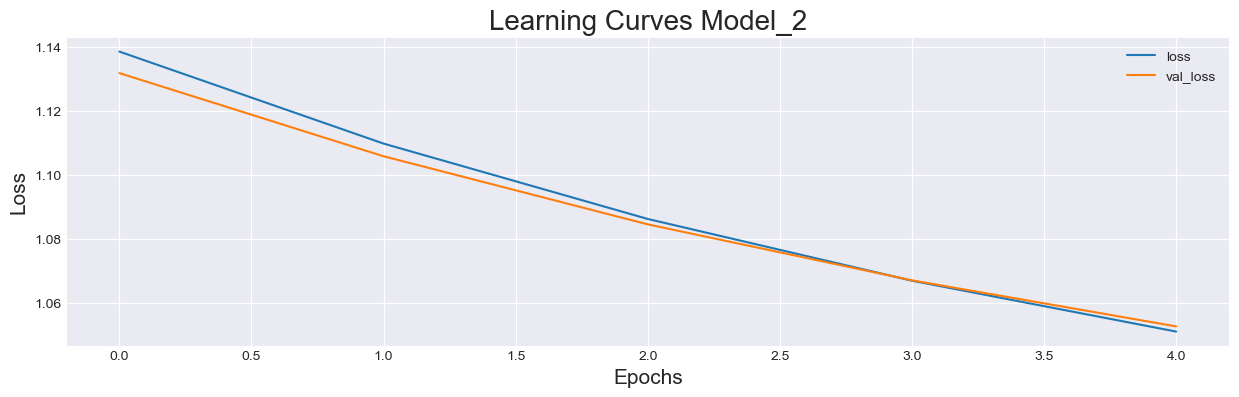

In [2109]:
pd.DataFrame(history_model_2.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_2", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [2111]:
# Evaluating the model
model_2.evaluate(test_dataset)

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0024 - mae: 1.0024 


[1.03615403175354, 1.03615403175354]

**Making Predictions**

In [2124]:
model_2_preds = model_2.predict(X_test_3d)
model_2_preds.shape

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


(9076, 1)

In [2116]:
# Showing the model_2 predictions in a DataFrame
pd.DataFrame(np.squeeze(model_2_preds))

,0
0,0.916697
1,0.908048
2,0.899404
3,0.889057
4,0.876337
...,...
9071,1.015874
9072,1.029426
9073,1.041048
9074,1.057177


In [2118]:
# Showing the directions of the predictions
pd.DataFrame(np.sign(model_2_preds)).value_counts()

0  
1.0    9076
Name: count, dtype: int64

**Note:**

Further tuning of the model's parameters is needed, as we can observe overfitting and that the model is forecasting only positive values.

### After tuning and testing several combination of hyperparameters in a separate branch...

- **Set the parametes the parameters as follows and**
- **Implemented kernel_regularizer**

In [2080]:
from tensorflow.keras.regularizers import l2

**Function with new settings**

In [2278]:
def run_conv1d(train_sets,
               val_sets,
               model_name,
               p_filters=32,
               p_kernel_size=5,
               p_strides=1,
               hidden_layers=2,
               p_epochs=25,
               dropout=0.20,
               lr=0.001,
               early_stopping_ptn=15,
               reduce_plateau_ptn=5,
               rp_lr=0.5,
               path="model_experiments",
               p_batch_size=256,
               kr_l2=0.1):

    for features, labels in train_sets.take(1):
        features_input_shape = features.shape[1:]
        break

    model = Sequential(name=model_name)

    # Input Layer
    model.add(Conv1D(name="input_layer_0", filters=p_filters, kernel_size=p_kernel_size, strides=p_strides, padding="causal", 
                    input_shape=features_input_shape, activation="relu", kernel_regularizer=l2(kr_l2)))

    # Hidden Layers
    for i in range(0, hidden_layers):
        model.add(Conv1D(filters=int(p_filters/2), kernel_size=p_kernel_size, activation="relu", kernel_regularizer=l2(kr_l2), name=f"hidden_layer{i}"))
        model.add(Dropout(dropout, name=f"dropput_layer{i}"))

    # Applying GlobalAveragePooling1D Layer
    model.add(GlobalAveragePooling1D())
        
    # Output Layer
    model.add(Dense(1, activation="linear", name="output_layer"))

    checkpoint_callback = ai.create_model_checkpoint(model.name, path)
    early_stopping = EarlyStopping(monitor="val_loss", patience=early_stopping_ptn, verbose=1)
    reduce_plateau = ReduceLROnPlateau(monitor="val_loss", factor=rp_lr, patience=reduce_plateau_ptn, verbose=2)

    # Compiling the model
    model.compile(loss="mae", optimizer=Adam(learning_rate=lr), metrics=["mae"])

    # Training the model
    history = model.fit(train_sets,
                       validation_data=val_sets,
                       batch_size=p_batch_size,
                       epochs=p_epochs,
                       verbose=1,
                       callbacks=[checkpoint_callback, early_stopping, reduce_plateau])

    return history

In [2577]:
history_model_3 = run_conv1d(train_sets=train_dataset,
                             val_sets=val_dataset,
                             model_name="model_3",
                             p_filters=8,
                             p_kernel_size=2,
                             p_strides=4,
                             hidden_layers=1,
                             p_epochs=5,
                             lr=0.0001,
                             early_stopping_ptn=3,
                             reduce_plateau_ptn=2,
                             kr_l2=0.05)

Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7349 - mae: 0.9885 - val_loss: 1.6549 - val_mae: 1.0088 - learning_rate: 1.0000e-04
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6014 - mae: 0.9854 - val_loss: 1.5319 - val_mae: 1.0017 - learning_rate: 1.0000e-04
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4820 - mae: 0.9774 - val_loss: 1.4292 - val_mae: 0.9971 - learning_rate: 1.0000e-04
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3912 - mae: 0.9808 - val_loss: 1.3448 - val_mae: 0.9954 - learning_rate: 1.0000e-04
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3103 - mae: 0.9791 - val_loss: 1.2747 - val_mae: 0.9944 - learning_rate: 1.0000e-04


**Model_3 Architecture**

In [2579]:
model_3 = load_model("model_experiments/model_3.keras")
model_3.summary()

Model: "model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_0 (Conv1D)          │ (None, 2, 8)           │           184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer0 (Conv1D)          │ (None, 1, 4)           │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropput_layer0 (Dropout)        │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_142    │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 773 (3.02 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 516 (2.02 KB)

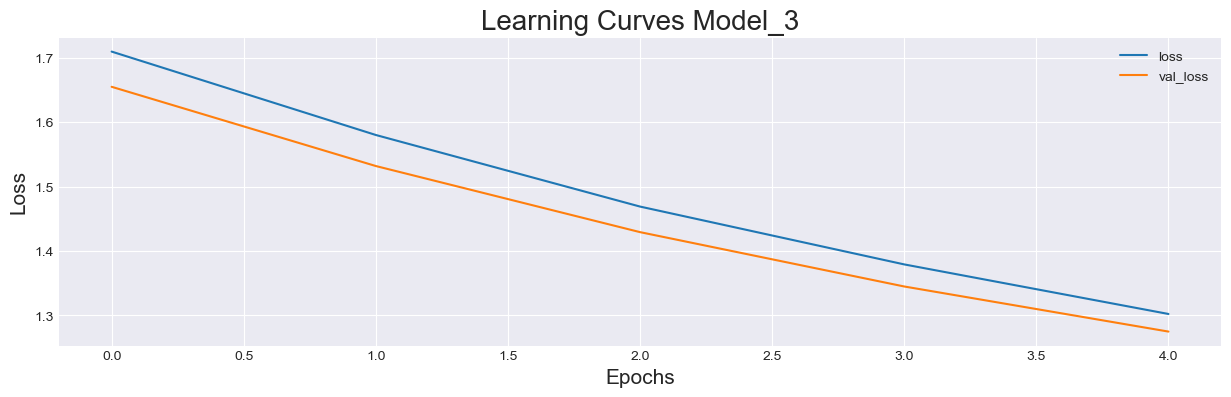

In [2580]:
pd.DataFrame(history_model_3.history)[["loss", "val_loss"]].plot(figsize=(15, 4))
plt.title("Learning Curves Model_3", fontsize=20)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [2581]:
# Evaluating the model_3
model_3.evaluate(test_dataset)

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2755 - mae: 0.9952  


[1.2761224508285522, 0.9957890510559082]

**Making predictions for Model 3**

In [2604]:
model_3_preds = model_3.predict(X_test_3d)
model_3_preds.shape

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


(9076, 1)

In [2610]:
# Showing the model predictions
pd.DataFrame(model_3_preds)

,0
0,0.021369
1,0.016212
2,0.002924
3,0.009306
4,-0.021028
...,...
9071,-0.011084
9072,-0.001332
9073,-0.017603
9074,0.005577


**Note:**

We now see the model has started forecasting prices in both directions

In [2617]:
# Count of model forecasted price directions
pd.DataFrame(np.sign(model_3_preds)).value_counts()

0   
 1.0    4561
-1.0    4515
Name: count, dtype: int64

**Computing returns for Model 3**

In [2646]:
returns_model_3 = backtest.compute_strategy_returns(y_test[5:], model_3_preds)
returns_model_3.head()

,pct_change,prediction,real_position,pred_position,returns
time,,,,,
2023-04-20 01:00:00,0.000522,0.021369,1.0,1.0,0.000522
2023-04-20 02:00:00,-0.000169,0.016212,-1.0,1.0,-0.000169
2023-04-20 03:00:00,0.001369,0.002924,1.0,1.0,0.001369
2023-04-20 04:00:00,0.000223,0.009306,1.0,1.0,0.000223
2023-04-20 05:00:00,-0.000758,-0.021028,-1.0,-1.0,0.000758


**Plotting the Cumulative Returns from Model 3**

Profits : -5.97%


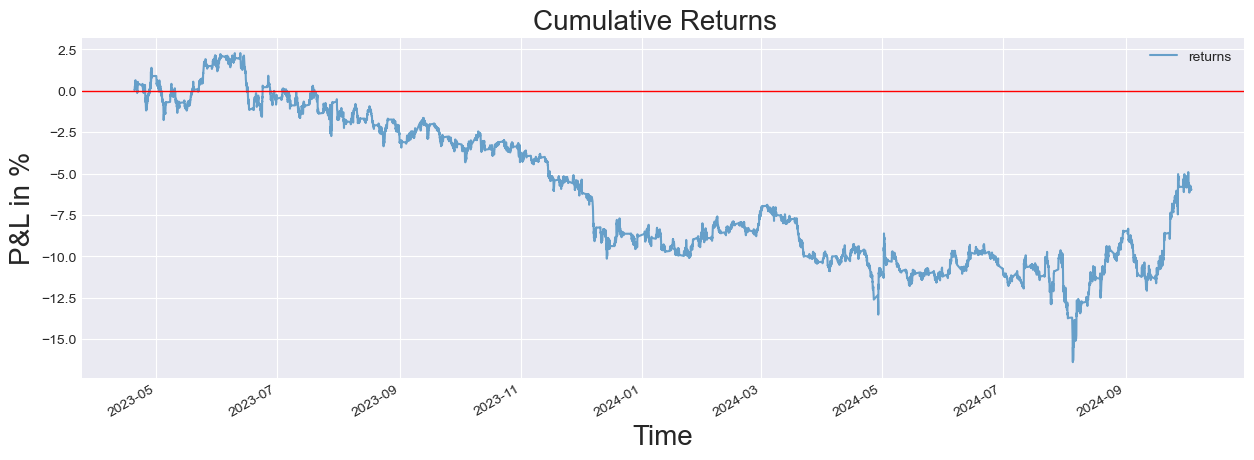

In [2642]:
display.plot_test_returns(returns_model_3["returns"])

**Confusion Matrix**

 It provides a detailed breakdown of the model's predictions, showing true positives, true negatives, false positives, and false negatives, which can be used to calculate metrics like accuracy and precision

In [2649]:
from sklearn.metrics import confusion_matrix

In [2651]:
confusion_matrix(returns_model_3["real_position"], returns_model_3["pred_position"])

array([[2157,    0, 2207],
       [  17,    0,   20],
       [2341,    0, 2334]], dtype=int64)

**Model 3 Analysis of Accuracy**

Counts of 0 indicate instances where the predicted position did not match the real position.
Counts of 1 indicate instances where the predicted position matched the real position.

accuracy
0    4585
1    4491
Name: count, dtype: int64

Model has an accuracy of: 49.48%


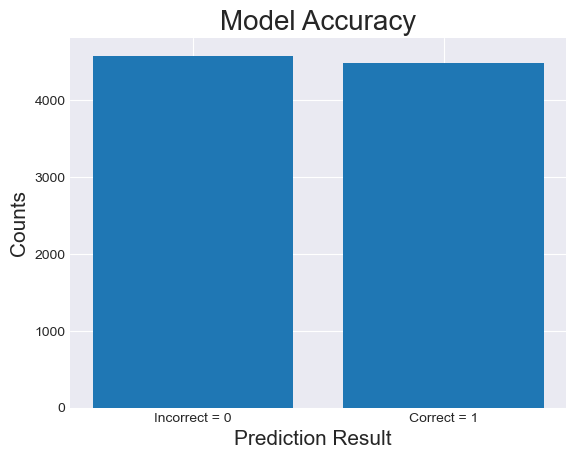

,real_position,pred_position,accuracy
time,,,
2023-04-20 01:00:00,1.0,1.0,1
2023-04-20 02:00:00,-1.0,1.0,0
2023-04-20 03:00:00,1.0,1.0,1
2023-04-20 04:00:00,1.0,1.0,1
2023-04-20 05:00:00,-1.0,-1.0,1


In [2654]:
backtest.compute_model_accuracy(returns_model_3["real_position"], returns_model_3["pred_position"])